In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import numpy as np
import numpy.linalg as la
from scipy.integrate import RK45

import sympy as sym
# Heaviside numerics workaround
sympy_modules = [{'Heaviside': lambda x: np.heaviside(x,0.5)}, 'numpy']

from table_maker import *
from functools import partial, reduce
from itertools import *
from math import ceil

import pickle

def cos_bell(x, center=0, width=2*np.pi, height=1):
    return (np.cos((x-center)/width*2*np.pi)+1)/2*height * np.heaviside(x-center+width/2,0) * np.heaviside(-x+center+width/2,0)

import collections.abc
def collect_eqn(expr, terms):
    if not isinstance(terms, collections.abc.Container):
        term = terms # isn't a list or tuple
        left, right = 0,0
        for my_expr in expr.args:
            has_term = False
            for my_term in sym.postorder_traversal(my_expr):
                if term == my_term:
                    has_term = True
                    break
            if has_term:
                left += my_expr
            else:
                right -= my_expr
        return sym.Eq(left, right, evaluate=False)
    else: # isn't a list or tuple
        left_total, right_total = 0, expr
        for term in terms:
            left, right = collect_eqn(right_total, term).args
            left_total += left
            right_total = -right
        return sym.Eq(left_total, right_total, evaluate=False)
    
def my_print(expr):
    global eviron_print_tex
    if eviron_print_tex:
        print('$$' + sym.latex(expr) + '$$')
    else:
        display(expr)
        
def batch_print(expr_list, punctuation='.', return_string=False):
    global eviron_print_tex
    if eviron_print_tex:
        print_str = '$$\\begin{align*}\n'
        for expr in expr_list:
            print_str += '\t' + sym.latex(expr).replace('=','&=') + '\\\\\n'
        # remove last new-line and add ending puncuation
        print_str = print_str[:-3] + punctuation + '\n'
        print_str += '\\end{align*}$$'
        if return_string:
            return print_str
        else:
            print(print_str)
    else:
        for expr in expr_list:
            display(expr)
            
def py_code(expr, replace_numpy=True, replace_unicode=True, numpy_package='np.'):
    code = sym.ccode(expr)
    
    if replace_unicode:
        unicode_replacements = [
            ('\\alpha', 'α'),
            ('\\beta', 'β'),
            ('\\gamma', 'γ'),
            ('\\Gamma', 'Γ'),
            ('\\delta', 'δ'),
            ('\\Delta', 'Δ'),
            ('\\epsilon', 'ϵ'),
            ('\\zeta', 'ζ'),
            ('\\eta', 'η'),
            ('\\theta', 'θ'),
            ('\\xi', 'ξ'),
            ('\\mu', 'μ')
        ]
        for unicode, symbol in unicode_replacements:
            code = code.replace(unicode, symbol)
    
    if replace_numpy:
        numpy_replacements = [
            ('exp', numpy_package + 'exp'),
            ('log', numpy_package + 'log'),
            ('pow', '( lambda base, exponent: base**exponent )'),
            ('Heaviside', '(lambda input: np.heaviside(input,0.5))')
        ]
        for c_func, np_func in numpy_replacements:
            code = code.replace(c_func, np_func)
        
    return code

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 24})

# Inhibitory Weight Kernel
$$\begin{align*}
    \mu u_t &= -u + \int_{-\infty}^\infty \big(M_1e^{-|x-x^\prime|/\sigma_1} - M_2e^{-|x-x^\prime|/\sigma_2} \big) f( u(x^\prime,t) - a(x^\prime,t)) \ dx^\prime \\
    \alpha a_t &= -a + \gamma f(u - a)
\end{align*}$$
This gives
$$
-c \mu U' + U = \begin{cases}
    \frac{M_2}{\sigma_2}e^{\xi/\sigma_2} - \frac{M_1}{\sigma_1}e^{\xi/\sigma_1} - \frac{M_2}{\sigma_2}e^{(\xi + \Delta)/\sigma_2} + \frac{M_1}{\sigma_1}e^{(\xi + \Delta)/\sigma_1}, & \xi < -\Delta \\
    2\frac{M_1}{\sigma_1} - 2\frac{M_2}{\sigma_2} - \frac{M_1}{\sigma_1}e^{(-\Delta-\xi)/\sigma_1} + \frac{M_2}{\sigma_2}e^{(-\Delta-\xi)/\sigma_2} + \frac{M2}{\sigma_2}e^{\xi/\sigma_2} - \frac{M_1}{\sigma_1}e^{\xi/\sigma_1}, & -\Delta \le \xi < 0 \\
    \frac{M_1}{\sigma_1}e^{-\xi/\sigma_1} - \frac{M_2}{\sigma_2}e^{-\xi/\sigma_2} - \frac{M_1}{\sigma_1}e^{(-\Delta-\xi)/\sigma_1} + \frac{M_2}{\sigma_2}e^{(-\Delta-\xi)/\sigma_2}, & 0 \le \xi
\end{cases}
$$

In [3]:
eviron_print_tex = False

μ, α, γ, τ, c, Δ = sym.symbols('\\mu \\alpha \\gamma, \\theta, c \\Delta', real=True, positive = True)
with open('profile.pickle', 'rb') as f:
    xs, Us, As, param_list = pickle.load(f)
    params = [μ, α,  γ,  τ, Δ, c]
    param_dict = {key:val for key,val in zip(params, param_list)}

x, xp, t, ξ, ξp = sym.symbols('x x^\\prime t \\xi \\xi^\\prime', real=True)
u = sym.Function('u', real=True)(x,t)
a = sym.Function('a', real=True)(x,t)
U = sym.Function('U', real=True)(ξ)
A = sym.Function('A', real=True)(ξ)

m1, m2, σ1, σ2 = sym.symbols('M_1 M_2 \\sigma_1 \\sigma_2', real=True, positive=True)

Fright = m1*σ1*sym.exp(-ξ/σ1) - m2*σ2*sym.exp(-ξ/σ2) - m1*σ1*sym.exp((-Δ-ξ)/σ1) + m2*σ2*sym.exp((-Δ-ξ)/σ2)
Fmid = 2*m1*σ1 - 2*m2*σ2 - m1*σ1*sym.exp((-Δ-ξ)/σ1) + m2*σ2*sym.exp((-Δ-ξ)/σ2) + m2*σ2*sym.exp(ξ/σ2) - m1*σ1*sym.exp(ξ/σ1)
Fleft = m2*σ2*sym.exp(ξ/σ2) - m1*σ1*sym.exp(ξ/σ1) - m2*σ2*sym.exp((ξ+Δ)/σ2) + m1*σ1*sym.exp((ξ+Δ)/σ1)
F = Fright*sym.Heaviside(ξ) + Fmid*sym.Heaviside(ξ+Δ)*sym.Heaviside(-ξ) + Fleft*sym.Heaviside(-ξ-Δ)
G =  γ*( sym.Heaviside(ξ+Δ) - sym.Heaviside(ξ) )


LU = lambda f: μ*c*f.diff(ξ) - f
LA = lambda f: α*c*f.diff(ξ) - f

##########################################################
#
# A homogeneous 
#
##########################################################

Ahom = sym.dsolve(LA(A), A).args[1].expand()
C1 = sym.symbols('C1')

##########################################################
#
# A right = 0 
#
##########################################################

Aright = 0

##########################################################
#
# A middle 
#
##########################################################

Gmid = γ
Amid = sym.dsolve(LA(A) + Gmid, ics={A.subs(ξ,0):0}).args[1].expand().collect(γ)

##########################################################
#
# A left 
#
##########################################################

C1exp = sym.solve(Ahom.subs(ξ, -Δ) - Amid.subs(ξ,-Δ), sym.exp(C1/α/c))[0]
Aleft = Ahom.subs(sym.exp(C1/α/c), C1exp)

##########################################################
#
# Combine to get A
#
##########################################################
Asub = sym.Piecewise( (Aleft, ξ<-Δ), (Amid, ξ<0), (Aright, True))


##########################################################
#
# U homogeneous 
#
##########################################################

Uhom = sym.dsolve(LU(U), U).args[1]
Uhom = Uhom.expand().subs(sym.exp(C1/μ/c), C1)

##########################################################
#
# Uright 
#
##########################################################
terms = [
    sym.exp(-ξ/σ1),
    sym.exp(-ξ/σ2),
    sym.exp((-Δ-ξ)/σ1),
    sym.exp((-Δ-ξ)/σ2)
]
coeffs = []
temp = sym.symbols('T')
for term in terms:
    coeff_sub = sym.solve((LU(term*temp) + Fright).collect(term).coeff(term), temp)[0]
    coeffs.append(coeff_sub)
    
Uright = Uhom.subs(C1, 0) + sum(c*term for c, term in zip(coeffs, terms))
Uright = Uright.collect(m1*σ1**2/(μ*c+σ1)).collect(m2*σ2**2/(μ*c+σ2))
assert (LU(Uright) + Fright).simplify() == 0

##########################################################
#
# Umid
#
##########################################################

terms = [
    sym.exp(ξ/σ1),
    sym.exp(ξ/σ2),
    sym.exp((-Δ-ξ)/σ1),
    sym.exp((-Δ-ξ)/σ2)
]
coeffs = []
temp = sym.symbols('T')
for term in terms:
    coeff_sub = sym.solve((LU(term*temp) + Fmid).collect(term).coeff(term), temp)[0]
    coeffs.append(coeff_sub)
# handle constant
coeff_sub = sym.solve((LU(temp) + Fmid).subs(dict(zip(terms, [0]*len(terms)))), temp)[0]
coeffs.append(coeff_sub)
terms.append(1)
    
Umid = Uhom + sum(c*term for c, term in zip(coeffs, terms))
C1_subs = -(Umid.subs(ξ,0) - τ).subs(C1, 0)
Umid = Umid.subs(C1, C1_subs)
assert (LU(Umid) + Fmid).simplify() == 0

##########################################################
#
# Uleft
#
##########################################################

terms = [
    sym.exp(ξ/σ1),
    sym.exp(ξ/σ2),
    sym.exp((Δ+ξ)/σ1),
    sym.exp((Δ+ξ)/σ2)
]
coeffs = []
temp = sym.symbols('T')
for term in terms:
    coeff_sub = sym.solve((LU(term*temp) + Fleft).collect(term).coeff(term), temp)[0]
    coeffs.append(coeff_sub)
    
Uleft = Uhom + sum(c*term for c, term in zip(coeffs, terms))
C1_subs = -(((Uleft - Aleft).subs(ξ, -Δ) - τ)*sym.exp(Δ/μ/c)).expand().subs(C1, 0)
Uleft = Uleft.subs(C1, C1_subs)
Uleft = Uleft.collect(sym.exp(Δ/σ1)).collect(sym.exp(Δ/σ2)).collect(sym.exp(Δ/μ/c)).collect(m1*σ1**2/(μ*c-σ1)).collect(m2*σ2**2/(μ*c-σ2))
assert (LU(Uleft) + Fleft).simplify() == 0

##########################################################
#
# Conditions
#
##########################################################

cond1 = Uright.subs(ξ, 0) - τ
cond2 = (Umid - Amid).subs(ξ, -Δ) - τ

##########################################################
#
# Piecewise
#
##########################################################

Usub = sym.Piecewise( (Uleft, ξ<-Δ), (Umid, ξ < 0), (Uright, True))
batch_print([sym.Eq(U, Usub), sym.Eq(A, Asub)])
print('with speed c and pulse-width Δ chosen such that')
batch_print([sym.Eq(0, cond1), sym.Eq(0, cond2)])

Eq(U(\xi), Piecewise((M_1*\sigma_1**2*(exp(\xi/\sigma_1) - exp((\Delta + \xi)/\sigma_1))/(\mu*c - \sigma_1) + M_2*\sigma_2**2*(-exp(\xi/\sigma_2) + exp((\Delta + \xi)/\sigma_2))/(\mu*c - \sigma_2) + (M_1*\sigma_1**2*(1 - exp(-\Delta/\sigma_1))/(\mu*c - \sigma_1) + M_2*\sigma_2**2*(-1 + exp(-\Delta/\sigma_2))/(\mu*c - \sigma_2) + \gamma - \gamma*exp(-\Delta/(\alpha*c)) + \theta)*exp(\Delta/(\mu*c))*exp(\xi/(\mu*c)), \Delta < -\xi), (-M_1*\sigma_1**2*exp((-\Delta - \xi)/\sigma_1)/(\mu*c + \sigma_1) + M_1*\sigma_1**2*exp(\xi/\sigma_1)/(\mu*c - \sigma_1) + 2*M_1*\sigma_1 + M_2*\sigma_2**2*exp((-\Delta - \xi)/\sigma_2)/(\mu*c + \sigma_2) - M_2*\sigma_2**2*exp(\xi/\sigma_2)/(\mu*c - \sigma_2) - 2*M_2*\sigma_2 + (M_1*\sigma_1**2*exp(-\Delta/\sigma_1)/(\mu*c + \sigma_1) - M_1*\sigma_1**2/(\mu*c - \sigma_1) - 2*M_1*\sigma_1 - M_2*\sigma_2**2*exp(-\Delta/\sigma_2)/(\mu*c + \sigma_2) + M_2*\sigma_2**2/(\mu*c - \sigma_2) + 2*M_2*\sigma_2 + \theta)*exp(\xi/(\mu*c)), \xi < 0), (M_1*\sigma_1**2*(-exp

Eq(A(\xi), Piecewise((\gamma*(exp(\Delta/(\alpha*c)) - 1)*exp(\xi/(\alpha*c)), \Delta < -\xi), (\gamma*(1 - exp(\xi/(\alpha*c))), \xi < 0), (0, True)))

with speed c and pulse-width Δ chosen such that


Eq(0, M_1*\sigma_1**2*(1 - exp(-\Delta/\sigma_1))/(\mu*c + \sigma_1) + M_2*\sigma_2**2*(-1 + exp(-\Delta/\sigma_2))/(\mu*c + \sigma_2) - \theta)

Eq(0, -M_1*\sigma_1**2/(\mu*c + \sigma_1) + M_1*\sigma_1**2*exp(-\Delta/\sigma_1)/(\mu*c - \sigma_1) + 2*M_1*\sigma_1 + M_2*\sigma_2**2/(\mu*c + \sigma_2) - M_2*\sigma_2**2*exp(-\Delta/\sigma_2)/(\mu*c - \sigma_2) - 2*M_2*\sigma_2 - \gamma*(1 - exp(-\Delta/(\alpha*c))) - \theta + (M_1*\sigma_1**2*exp(-\Delta/\sigma_1)/(\mu*c + \sigma_1) - M_1*\sigma_1**2/(\mu*c - \sigma_1) - 2*M_1*\sigma_1 - M_2*\sigma_2**2*exp(-\Delta/\sigma_2)/(\mu*c + \sigma_2) + M_2*\sigma_2**2/(\mu*c - \sigma_2) + 2*M_2*\sigma_2 + \theta)*exp(-\Delta/(\mu*c)))

# Root find

In [4]:
param_dict = {
    μ: 1,
    α: 5,
    γ: 3,
    τ: 0.1,
    m1: 3,
    m2: 1,
    σ1: 1,
    σ2: 2,
}

F = sym.Matrix([[cond1], [cond2]]).subs(param_dict)

# jac = sym.Matrix([[f.diff(var) for f in F] for var in [c, Δ]])
jac = sym.Matrix([[f.diff(var) for var in [c, Δ]] for f in F] )

Fnum = sym.lambdify((c, Δ), F, 'numpy')
Jnum = sym.lambdify((c, Δ), jac, 'numpy')

In [52]:
temp = np.array([[1.4028042056102772],
                 [7.407407407407412]])
# temp = np.array([[.3827641455270858],
#                  [7.207207207207212]])
for _ in range(10):
    temp -= la.solve(Jnum(*temp.flatten()), Fnum(*temp.flatten()))
    #print(Fnum(*temp.flatten()))
    
param_dict[c], param_dict[Δ] = temp.flatten()

Unum = sym.lambdify(ξ, Usub.subs(param_dict), 'numpy')
print(param_dict)

# θ = τ
# save_dict = {
#     s: param_dict[eval(s)]
#     for s in ['μ', 'α', 'γ', 'θ', 'm1', 'm2','σ1', 'σ2', 'c', 'Δ']
# }
# with open('exp_diff_params.pickle', 'wb') as f:
#     pickle.dump(save_dict, f)

{\mu: 1, \alpha: 5, \gamma: 3, \theta: 0.1, M_1: 3, M_2: 1, \sigma_1: 1, \sigma_2: 2, c: 1.4206352135572324, \Delta: 7.2672972146810135}


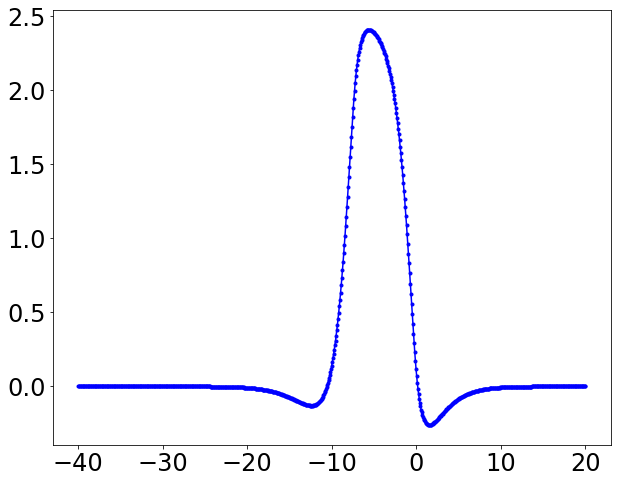

In [6]:
plt.figure(figsize=(10,8))
xs = np.linspace(-40, 20, 801)
plt.plot(xs, Unum(xs), 'b.-')
# Umid_num = sym.lambdify(ξ, Umid.subs(param_dict), 'numpy')
# plt.plot(xs, Umid_num(xs), 'k.-')
# plt.ylim(-1, 5)
plt.show()

In [7]:
Utest = sym.Heaviside(-ξ-Δ)*Uleft + sym.Heaviside(-ξ)*sym.Heaviside(ξ+Δ)*Umid + sym.Heaviside(ξ)*Uright
Atest = sym.Heaviside(-ξ-Δ)*Aleft + sym.Heaviside(-ξ)*sym.Heaviside(ξ+Δ)*Amid + sym.Heaviside(ξ)*Aright

# Heaviside numerics workaround
# sympy_modules = [{'Heaviside': lambda x: np.heaviside(x,0.5)}, 'numpy']

# Unumeric = sym.lambdify(ξ, Utest.subs(param_dict), modules=sympy_modules)
# Anumeric = sym.lambdify(ξ, Atest.subs(param_dict), modules=sympy_modules)

code_replace_dict = {
    '\\sigma_1' : 'σ1',
    '\\sigma_2' : 'σ2',
    'M_1' : 'm1',
    'M_2' : 'm2'
}

code = 'def Unum(ξ, μ, α, γ, θ, Δ, c, m1, s1, m2, s2):\n\treturn ' + py_code(Utest)
for key, val in code_replace_dict.items():
    code = code.replace(key, val)
print(code)

code = 'def Anum(ξ, μ, α, γ, θ, Δ, c, m1, s1, m2, s2):\n\treturn ' + py_code(Atest)
for key, val in code_replace_dict.items():
    code = code.replace(key, val)
print(code)

def Unum(ξ, μ, α, γ, θ, Δ, c, m1, s1, m2, s2):
	return // Not supported in C:
// (lambda input: np.heaviside(input,0.5))
// (lambda input: np.heaviside(input,0.5))
// (lambda input: np.heaviside(input,0.5))
// (lambda input: np.heaviside(input,0.5))
(m1*( lambda base, exponent: base**exponent )(σ1, 2)*(-np.exp((-Δ - ξ)/σ1) + np.exp(-ξ/σ1))/(μ*c + σ1) + m2*( lambda base, exponent: base**exponent )(σ2, 2)*(np.exp((-Δ - ξ)/σ2) - np.exp(-ξ/σ2))/(μ*c + σ2))*(lambda input: np.heaviside(input,0.5))(ξ) + (m1*( lambda base, exponent: base**exponent )(σ1, 2)*(np.exp(ξ/σ1) - np.exp((Δ + ξ)/σ1))/(μ*c - σ1) + m2*( lambda base, exponent: base**exponent )(σ2, 2)*(-np.exp(ξ/σ2) + np.exp((Δ + ξ)/σ2))/(μ*c - σ2) + (m1*( lambda base, exponent: base**exponent )(σ1, 2)*(1 - np.exp(-Δ/σ1))/(μ*c - σ1) + m2*( lambda base, exponent: base**exponent )(σ2, 2)*(-1 + np.exp(-Δ/σ2))/(μ*c - σ2) + γ - γ*np.exp(-Δ/(α*c)) + θ)*np.exp(Δ/(μ*c))*np.exp(ξ/(μ*c)))*(lambda input: np.heaviside(input,0.5))(-Δ - ξ) + (-m1*( lamb

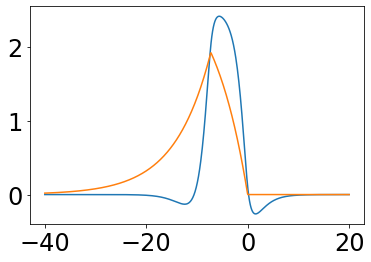

In [8]:
def Unum(ξ, μ, α, γ, θ, Δ, c, m1, σ1, m2, σ2):
    return (m1*( lambda base, exponent: base**exponent )(σ1, 2)*(-np.exp((-Δ - ξ)/σ1) + np.exp(-ξ/σ1))/(μ*c + σ1) + m2*( lambda base, exponent: base**exponent )(σ2, 2)*(np.exp((-Δ - ξ)/σ2) - np.exp(-ξ/σ2))/(μ*c + σ2))*(lambda input: np.heaviside(input,0.5))(ξ) + (m1*( lambda base, exponent: base**exponent )(σ1, 2)*(np.exp(ξ/σ1) - np.exp((Δ + ξ)/σ1))/(μ*c - σ1) + m2*( lambda base, exponent: base**exponent )(σ2, 2)*(-np.exp(ξ/σ2) + np.exp((Δ + ξ)/σ2))/(μ*c - σ2) + (m1*( lambda base, exponent: base**exponent )(σ1, 2)*(1 - np.exp(-Δ/σ1))/(μ*c - σ1) + m2*( lambda base, exponent: base**exponent )(σ2, 2)*(-1 + np.exp(-Δ/σ2))/(μ*c - σ2) + γ - γ*np.exp(-Δ/(α*c)) + θ)*np.exp(Δ/(μ*c))*np.exp(ξ/(μ*c)))*(lambda input: np.heaviside(input,0.5))(-Δ - ξ) + (-m1*( lambda base, exponent: base**exponent )(σ1, 2)*np.exp((-Δ - ξ)/σ1)/(μ*c + σ1) + m1*( lambda base, exponent: base**exponent )(σ1, 2)*np.exp(ξ/σ1)/(μ*c - σ1) + 2*m1*σ1 + m2*( lambda base, exponent: base**exponent )(σ2, 2)*np.exp((-Δ - ξ)/σ2)/(μ*c + σ2) - m2*( lambda base, exponent: base**exponent )(σ2, 2)*np.exp(ξ/σ2)/(μ*c - σ2) - 2*m2*σ2 + (m1*( lambda base, exponent: base**exponent )(σ1, 2)*np.exp(-Δ/σ1)/(μ*c + σ1) - m1*( lambda base, exponent: base**exponent )(σ1, 2)/(μ*c - σ1) - 2*m1*σ1 - m2*( lambda base, exponent: base**exponent )(σ2, 2)*np.exp(-Δ/σ2)/(μ*c + σ2) + m2*( lambda base, exponent: base**exponent )(σ2, 2)/(μ*c - σ2) + 2*m2*σ2 + θ)*np.exp(ξ/(μ*c)))*(lambda input: np.heaviside(input,0.5))(-ξ)*(lambda input: np.heaviside(input,0.5))(Δ + ξ)
def Anum(ξ, μ, α, γ, θ, Δ, c, m1, σ1, m2, σ2):
    return γ*(1 - np.exp(ξ/(α*c)))*(lambda input: np.heaviside(input,0.5))(-ξ)*(lambda input: np.heaviside(input,0.5))(Δ + ξ) + γ*(np.exp(Δ/(α*c)) - 1)*np.exp(ξ/(α*c))*(lambda input: np.heaviside(input,0.5))(-Δ - ξ)

numeric_params_dict = {
    'μ' : param_dict[μ],
    'α' : param_dict[α],
    'γ' : param_dict[γ],
    'θ' : param_dict[τ],
    'Δ' : param_dict[Δ],
    'c' : param_dict[c],
    'm1': param_dict[m1],
    'm2': param_dict[m2],
    'σ1': param_dict[σ1],
    'σ2': param_dict[σ2],
}

with open('param_dict_exp_diff.pickle', 'wb') as f:
    pickle.dump(numeric_params_dict, f)



plt.plot(xs, Unum(xs, **numeric_params_dict))
plt.plot(xs, Anum(xs, **numeric_params_dict))
plt.show()

In [85]:
response_coeff = sym.integrate((-μ*Uright.diff(ξ)*sym.exp(-ξ/c/μ)).expand(), (ξ, 0, sym.oo))
expr = response_coeff.collect(sym.exp(Δ/σ1)).collect(sym.exp(Δ/σ2))
sub1 = (μ*c+σ1)**2
sub2 = (μ*c+σ2)**2
expr = expr.subs(sub1.expand(), sub1).subs(sub2.expand(), sub2)
expr = expr.collect( m1*μ**2*σ1**2*c/sub1 ).collect( m2*μ**2*σ2**2*c/sub2 )
assert (response_coeff - expr).simplify() == 0
response_coeff = expr

In [86]:
tau = sym.symbols('\\tau')
I = sym.Function('I')
wave_response = 1/response_coeff * sym.integrate(
                                        sym.integrate(
                                            sym.exp(-ξ/c/μ)*I(ξ,tau), 
                                            (ξ, 0, sym.oo)),
                                        (tau, 0, t))
display(wave_response)

Integral(I(\xi, \tau)*exp(-\xi/(\mu*c)), (\xi, 0, oo), (\tau, 0, t))/(M_1*\mu**2*\sigma_1**2*c*(1 - exp(-\Delta/\sigma_1))/(\mu*c + \sigma_1)**2 + M_2*\mu**2*\sigma_2**2*c*(-1 + exp(-\Delta/\sigma_2))/(\mu*c + \sigma_2)**2)

In [90]:
print(sym.latex(
wave_response.subs(I(ξ, tau), 1).doit().subs(t, 1)#.subs(param_dict).evalf()
))

\frac{\mu c}{\frac{M_{1} \mu^{2} \sigma_{1}^{2} c \left(1 - e^{- \frac{\Delta}{\sigma_{1}}}\right)}{\left(\mu c + \sigma_{1}\right)^{2}} + \frac{M_{2} \mu^{2} \sigma_{2}^{2} c \left(-1 + e^{- \frac{\Delta}{\sigma_{2}}}\right)}{\left(\mu c + \sigma_{2}\right)^{2}}}


In [88]:
param_dict

{\mu: 1,
 \alpha: 5,
 \gamma: 3,
 \theta: 0.1,
 M_1: 3,
 M_2: 1,
 \sigma_1: 1,
 \sigma_2: 2,
 c: 1.4206352135572324,
 \Delta: 7.2672972146810135}

In [98]:
def param_dict_print(param_dict):
    print(', '.join(f'${key}={value:.4g}$' for key, value in param_dict.items()))
        
param_dict_print(param_dict)

$\mu=1$, $\alpha=5$, $\gamma=3$, $\theta=0.1$, $M_1=3$, $M_2=1$, $\sigma_1=1$, $\sigma_2=2$, $c=1.421$, $\Delta=7.267$
